# Tryout Notebook for ResNet50 model

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and inital setup

In [1]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import sys

sys.path.append("..")
from helperfunctions import modelhelper as mh

SEED = 42
NUM_EPOCHS = 10

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL="dx"
BALANCE_LABEL="dx"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

### Loading (augmented) metadata as test, train, validation from files

In [2]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
173,HAM_0006805,ISIC_0029772.jpg,nv,follow_up,50.0,male,back,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0029772.jpg
1170,HAM_0004620,ISIC_0033122.jpg,mel,histo,55.0,male,trunk,vidir_modern,skin_cancer,./../data/jpgs/ISIC_0033122.jpg
3212,HAM_0005918,aug_rXxrCtISIC_0029177.jpg,df,consensus,35.0,female,lower extremity,vidir_molemax,not_skin_cancer,./../data/jpgs/aug_rXxrCtISIC_0029177.jpg
3054,HAM_0002450,ISIC_0024396.jpg,df,consensus,65.0,female,lower extremity,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0024396.jpg
2373,HAM_0006852,aug_ozCklkISIC_0032715.jpg,vasc,consensus,45.0,female,abdomen,vidir_modern,not_skin_cancer,./../data/jpgs/aug_ozCklkISIC_0032715.jpg
2262,HAM_0004791,aug_XalNoFISIC_0033135.jpg,vasc,histo,80.0,female,lower extremity,vidir_modern,not_skin_cancer,./../data/jpgs/aug_XalNoFISIC_0033135.jpg
1011,HAM_0004153,ISIC_0026489.jpg,mel,histo,80.0,male,foot,vidir_modern,skin_cancer,./../data/jpgs/ISIC_0026489.jpg
1407,HAM_0005533,ISIC_0027065.jpg,mel,histo,85.0,female,upper extremity,rosendahl,skin_cancer,./../data/jpgs/ISIC_0027065.jpg
1462,HAM_0005409,ISIC_0032970.jpg,mel,histo,45.0,male,back,vidir_modern,skin_cancer,./../data/jpgs/ISIC_0032970.jpg
2611,HAM_0002749,ISIC_0025066.jpg,bkl,histo,60.0,male,upper extremity,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0025066.jpg


## Setting up the image data generator for training and validation

In [3]:
# Setting up the Image Data Generator for the train data set - including augmentation

datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1], important for CNNs to perform better, deactivate to see images down below
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0 #see above
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=32
)

Found 2003 validated image filenames belonging to 7 classes.
Found 3504 validated image filenames belonging to 7 classes.


## ResNet50


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import math

# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
x = Dense(1024, activation='relu')(x) # fully connected layer with 1024 neurons and ReLU activation, relu is used to introduce non-linearity
predictions = Dense(num_classes, activation='softmax')(x) #  output layer with a number of neurons equal to the number of classes (determined by num_classes) and a softmax activation function for multi-class classification.

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


# Freeze all layers in the entire model
for layer in model.layers:
    layer.trainable = False


# Define differential learning rates for different layers
lr_rates = {
    'dense_1': 1e-3,  # Adjust the learning rate for the dense layer
    'dense_2': 1e-4,  # Adjust the learning rate for the output layer
}

# Implement learning rate scheduler with cosine annealing
def cosine_annealing(epoch):
    max_lr = lr_rates['dense_1']
    min_lr = lr_rates['dense_2']
    total_epochs = 10  # Adjust the total number of epochs
    cos_val = (1 + math.cos(math.pi * epoch / total_epochs)) / 2
    return min_lr + (max_lr - min_lr) * cos_val

lr_scheduler = LearningRateScheduler(cosine_annealing) # Applying a Learning rate scheduler

# Compile the model with a custom optimizer (SGD with momentum)
custom_optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define checkpoints to save the best model
#checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

## Model Training

In [5]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,                # Set the batch size, default is 32, can be increased to speed up training, but memory consumption increases
    callbacks=[lr_scheduler],                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/10
110/110 [==============================] - 205s 2s/step - loss: 2.3014 - accuracy: 0.1430 - val_loss: 2.5779 - val_accuracy: 0.0514 - lr: 0.0010
Epoch 2/10
110/110 [==============================] - 220s 2s/step - loss: 2.3014 - accuracy: 0.1430 - val_loss: 2.5779 - val_accuracy: 0.0514 - lr: 9.7798e-04
Epoch 3/10
110/110 [==============================] - 221s 2s/step - loss: 2.3014 - accuracy: 0.1430 - val_loss: 2.5779 - val_accuracy: 0.0514 - lr: 9.1406e-04
Epoch 4/10
110/110 [==============================] - 223s 2s/step - loss: 2.3014 - accuracy: 0.1430 - val_loss: 2.5779 - val_accuracy: 0.0514 - lr: 8.1450e-04
Epoch 5/10
 52/110 [=============>................] - ETA: 1:11 - loss: 2.2921 - accuracy: 0.1475

KeyboardInterrupt: 

## Plotting accuracy and loss of train and validation set

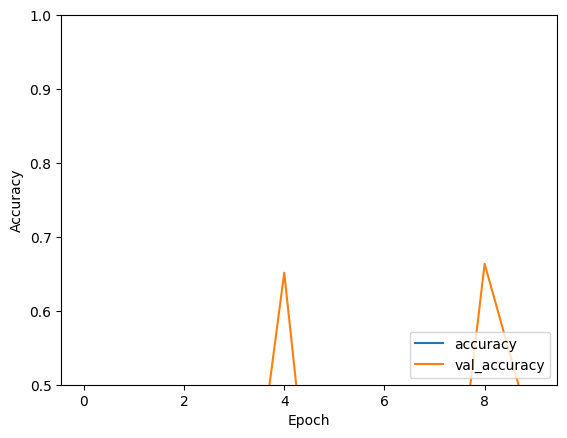

In [ ]:
mh.model_plot_accuracy(history)

## Evaluating the model on the test set

In [ ]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

63/63 - 92s - loss: 1.8327 - accuracy: 0.2292 - 92s/epoch - 1s/step


In [ ]:
def print_report(y_test, y_pred):
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 10})
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
print_report(test_df, y_pred)

## Saving the model

In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
